# <center>M2 DataScience - Université d'Angers </center>
##  <center>  Generative Adversarial Networks  </center>

Ce TP a pour objectif d'expérimenter les Generative Adversarial Networks (GANs) sur un problème de génération de visages.

De manière classique, un GAN se formule selon un problème adverse de la manière suivante:
$$\min\limits_{G} \max\limits_D V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(z)))\big]$$
Cette formulation met en jeu deux réseaux adverse:
*   Un réseau discriminateur $D$, dont l'objectif est de savoir distinguer les données réelles des données simulées  
*   Un réseau générateur $G$, dont l'objectif est de flouer le discriminateur

À l'optimum, avec des réseaux de capacité infinie, la distribution $p_G$ des données générées par $G$ est prouvée suivre la distribution des données réelles $p_{data}$. Bien sûr nous ne travaillons pas avec des réseaux de capacité infinie (et d'ailleurs heureusement car on ne veut pas apprendre par coeur les données d'apprentissage), mais l'objectif est d'approcher cette distribution $p_{data}$ en apprenant un générateur neuronal dont les sorties sont difficilement distinguables des vraies données pour le discriminateur.

Nous proposons de mettre ce genre d'architecture pour un la génération de visages: selon un ensemble de visages d'entraînement, il s'agit d'apprendre à générer des visages qui paraissent les plus réalistes possibles tout en conservant une certaine diversité dans les distributions de sortie. Pour cela nous emploierons une architecture DCGAN, qui utilise des réseaux de neurones convolutionnels (CNNs) pour le générateur et le discriminateur.    






Pour ce TP, nous vous proposons de travailler avec Google Colab qui est un service notebook en ligne avec ressources machines à disposition (nécessite d'être connecté à un compte google personnel):
*   https://colab.research.google.com/
*   Ouvrir ce Notebook avec "File>Upload Notebook"
*   Sélectionner un Runtime GPU : Runtime>Change Runtime Type (utile de le faire avant tout téléchargement de données car le changement de Runtime efface les données temporaires de la session)

Pour télécharger les données utiles au TP:


*   Aller à l'adresse : https://drive.google.com/open?id=0B7EVK8r0v71pWEZsZE9oNnFzTm8
*   Clic-droit sur CelebA, Ajouter à mon Drive
*   Exécuter le code ci-dessous (une autorisation vous sera demandée, suivre le lien donné à l'exécution pour obtenir le code d'authentification)

(Sinon vous pouvez aussi travailler en local en téléchargeant les données sur votre ordinateur mais attention fichier volumineux et colab propose des ressources GPU utiles à la résolution du TP)

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Vous devez maintenant avoir dans le paneau de gauche un onglet Files contenant un répertoire drive dans l'arborescence. C'est votre espace de stockage Google Drive. Il devrait contenir un répertoire CelebA (si ce n'est pas le cas attendre un peu et rafraichir, il peut mettre un certain temps à apparaître).

Il s'agit maintenant de décompresser l'archive téléchargée (cela peut prendre jusqu'à une dizaine de minutes):



In [2]:
! unzip drive/My\ Drive/CelebA/Img/img_align_celeba.zip -d data

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
 extracting: data/img_align_celeba/197600.jpg  
 extracting: data/img_align_celeba/197601.jpg  
 extracting: data/img_align_celeba/197602.jpg  
 extracting: data/img_align_celeba/197603.jpg  
 extracting: data/img_align_celeba/197604.jpg  
 extracting: data/img_align_celeba/197605.jpg  
 extracting: data/img_align_celeba/197606.jpg  
 extracting: data/img_align_celeba/197607.jpg  
 extracting: data/img_align_celeba/197608.jpg  
 extracting: data/img_align_celeba/197609.jpg  
 extracting: data/img_align_celeba/197610.jpg  
 extracting: data/img_align_celeba/197611.jpg  
 extracting: data/img_align_celeba/197612.jpg  
 extracting: data/img_align_celeba/197613.jpg  
 extracting: data/img_align_celeba/197614.jpg  
 extracting: data/img_align_celeba/197615.jpg  
 extracting: data/img_align_celeba/197616.jpg  
 extracting: data/img_align_celeba/197617.jpg  
 extracting: data/img_align_celeba/197618.jpg  
 extractin

Cela produit un répertoire data à la racine du repertoire temporaire de votre Google Colab. Ce repertoire contient un sous-repertoire img_align_celeba contenant une liste de 202599 fichiers jpg correspondant à des photos de visages de célébrités (attention ce repertoire est temporaire, tout ce qui n'est pas dans un drive est effacé à la fin de la session).



In [3]:
import numpy as np
try:
    import torch
except:
    !pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html
    import torch

import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.utils.data
import torchvision.datasets as dset
import torchvision.utils as vutils
import torch.backends.cudnn as cudnn


Le code ci-dessous permet de déclarer la manière de charger les données.

Lorsque des données sont demandées (pour la construction d'un nouveau batch par exemple), une série de transformations est appliquée sur les images, selon la composition de transformateurs déclarée pour le chargement:
*    redimentionnement des images en 64 par 64
*    recadrage au centre (qui ne fait rien ici car image déjà dans la taille du cadre mais si utile pour d'autres paramètres)
*    conversion en tenseur pytorch
*    normalisation des valeurs RGB selon une moyenne de 0.5 et un ecart-type de 0.5.



In [4]:
image_size = 64
dataset = dset.ImageFolder(root="data",
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [5]:
print(dataset)

Dataset ImageFolder
    Number of datapoints: 202599
    Root location: data
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


Le code ci-dessous permet de déclarer la manière de charger les images et en affiche un échantillon.

In [8]:
import matplotlib.pyplot as plt
import os



seed=0
torch.manual_seed(seed)
np.random.seed(seed)
device=0
if device>=0 and torch.cuda.is_available():
  cudnn.benchmark = True
  torch.cuda.device(device)
  torch.cuda.manual_seed(seed)
else:
  device=-1 if torch.cuda.is_available() else "cpu"

batch_size = 128
workers = 2

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Affichage de quelques images
real_batch = next(iter(dataloader)) #real_batch est une liste de 2 tenseurs où le 1er correspond aux images, les second correspond aux labels (ici 0 partout)

plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=1, normalize=True).cpu(),(1,2,0)))
os.makedirs("drive/My Drive/Colab Notebooks/tp_gan/genFaces",exist_ok=True)
plt.savefig("drive/My Drive/Colab Notebooks/tp_gan/genFaces/train.png" ) # Pour sauvegarder l'image sur votre Google Drive


Output hidden; open in https://colab.research.google.com to view.

Le réseau $D$ est un empilement de couches de convolution 2D avec batchNorm2D et activations RELU:

In [9]:
nc = 3 # Nombre de canaux de l'entrée
ndf = 64 # Facteur du nombre de canaux de sortie des différentes couches de convolution


# Initialisation recommandee pour netG et netD dans DCGAN
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [10]:
nz=100  #Taille du vecteur z donné en entrée du générateur
ngf = 64 # Facteur du nombre de canaux de sortie des différentes couches de deconvolution

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

 ###### Une version du Generator de GAN classique "original" ######
"""
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            # Première couche : projection du vecteur latent
            nn.Linear(nz, ngf * 8 * 8 * 8),
            nn.ReLU(True),
            # remodelage pour simuler des "features maps"
            nn.Unflatten(1, (ngf * 8, 8, 8)),
            # Couches fully-connected simulées
            nn.Linear(ngf * 8 * 8 * 8, ngf * 4 * 16 * 16),
            nn.ReLU(True),
            nn.Linear(ngf * 4 * 16 * 16, ngf * 2 * 32 * 32),
            nn.ReLU(True),
            nn.Linear(ngf * 2 * 32 * 32, nc * 64 * 64),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input).view(-1, nc, 64, 64)
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)
"""

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


'\nclass Generator(nn.Module):\n    def __init__(self):\n        super(Generator, self).__init__()\n\n        self.main = nn.Sequential(\n            # Première couche : projection du vecteur latent\n            nn.Linear(nz, ngf * 8 * 8 * 8),\n            nn.ReLU(True),\n            # remodelage pour simuler des "features maps"\n            nn.Unflatten(1, (ngf * 8, 8, 8)),\n            # Couches fully-connected simulées\n            nn.Linear(ngf * 8 * 8 * 8, ngf * 4 * 16 * 16),\n            nn.ReLU(True),\n            nn.Linear(ngf * 4 * 16 * 16, ngf * 2 * 32 * 32),\n            nn.ReLU(True),\n            nn.Linear(ngf * 2 * 32 * 32, nc * 64 * 64),\n            nn.Tanh()\n        )\n\n    def forward(self, input):\n        return self.main(input).view(-1, nc, 64, 64)\nnetG = Generator().to(device)\nnetG.apply(weights_init)\nprint(netG)\n'

Donner la procédure d'entraînement de ces deux réseaux. L'optimisation se fera ADAM selon les deux coûts adverses du discriminateur et du générateur. Pour chaque nouveau batch d'images, on alterne les deux mises à jour suivantes, selon un batch de vecteurs $z$ tirés aléatoirement selon une loi normale centrée réduite (un nouveau batch de $z$ à chaque itération):

1.   Un pas de gradient sur les paramètres du réseau D pour maximiser:  $log(D(x)) + log(1 - D(G(z)))$
2.   Un pas de gradient sur les paramètres du réseau G pour maximiser:  $log(D(G(z)))$


Afin de suivre l'évolution de l'apprentissage, on pourra logguer l'erreur du discriminateur relevée en 1, l'erreur du générateur relevée en 2, la moyenne des sorties du discriminateur sur les images réelles et la moyenne des sorties du discriminateur sur les images générées.

À la fin de chaque époque (i.e., lorsque l'on a itéré sur tous les batchs du DataLoader), on pourra enregistrer les images générées à partir d'un batch de vecteurs $z$ fixe dans le Google Drive pour observer l'évolution des capacités du générateur.  



  0%|          | 0/1583 [00:00<?, ?it/s]

[1/10][0/1583] Loss_D: 1.1167 Loss_G: 5.9487 D(x): 0.7069 D(G(z)): 0.7801 / 0.0049
[1/10][158/1583] Loss_D: 0.0108 Loss_G: 9.4529 D(x): 0.9901 D(G(z)): 0.0049 / 0.0002
[1/10][316/1583] Loss_D: 0.0161 Loss_G: 10.3232 D(x): 0.9986 D(G(z)): 0.0297 / 0.0001
[1/10][474/1583] Loss_D: 0.0207 Loss_G: 9.2035 D(x): 0.9942 D(G(z)): 0.0320 / 0.0003
[1/10][632/1583] Loss_D: 0.0180 Loss_G: 10.2682 D(x): 0.9748 D(G(z)): 0.0019 / 0.0015
[1/10][790/1583] Loss_D: 0.0153 Loss_G: 9.7107 D(x): 0.9816 D(G(z)): 0.0023 / 0.0002
[1/10][948/1583] Loss_D: 0.0200 Loss_G: 9.2842 D(x): 0.9967 D(G(z)): 0.0320 / 0.0007
[1/10][1106/1583] Loss_D: 0.0092 Loss_G: 10.5484 D(x): 0.9865 D(G(z)): 0.0013 / 0.0004
[1/10][1264/1583] Loss_D: 0.0059 Loss_G: 8.4624 D(x): 0.9942 D(G(z)): 0.0050 / 0.0004
[1/10][1422/1583] Loss_D: 0.0251 Loss_G: 8.7072 D(x): 0.9986 D(G(z)): 0.0416 / 0.0007
[1/10][1580/1583] Loss_D: 0.0027 Loss_G: 8.4196 D(x): 0.9996 D(G(z)): 0.0047 / 0.0011


  0%|          | 0/1583 [00:00<?, ?it/s]

[2/10][0/1583] Loss_D: 0.0038 Loss_G: 8.4151 D(x): 0.9964 D(G(z)): 0.0036 / 0.0011
[2/10][158/1583] Loss_D: 0.0363 Loss_G: 8.7616 D(x): 0.9812 D(G(z)): 0.0233 / 0.0107
[2/10][316/1583] Loss_D: 0.0009 Loss_G: 11.5518 D(x): 0.9997 D(G(z)): 0.0015 / 0.0002
[2/10][474/1583] Loss_D: 0.0379 Loss_G: 9.5559 D(x): 0.9825 D(G(z)): 0.0249 / 0.0014
[2/10][632/1583] Loss_D: 0.0145 Loss_G: 7.5043 D(x): 0.9965 D(G(z)): 0.0237 / 0.0018
[2/10][790/1583] Loss_D: 0.0494 Loss_G: 5.8110 D(x): 0.9753 D(G(z)): 0.0612 / 0.0069
[2/10][948/1583] Loss_D: 0.0445 Loss_G: 6.0518 D(x): 0.9613 D(G(z)): 0.0170 / 0.0069
[2/10][1106/1583] Loss_D: 0.0141 Loss_G: 9.3780 D(x): 0.9821 D(G(z)): 0.0059 / 0.0004
[2/10][1264/1583] Loss_D: 0.0084 Loss_G: 9.9610 D(x): 0.9939 D(G(z)): 0.0098 / 0.0008
[2/10][1422/1583] Loss_D: 0.0031 Loss_G: 9.7902 D(x): 0.9955 D(G(z)): 0.0016 / 0.0003
[2/10][1580/1583] Loss_D: 0.0781 Loss_G: 8.1654 D(x): 0.9130 D(G(z)): 0.0015 / 0.0059


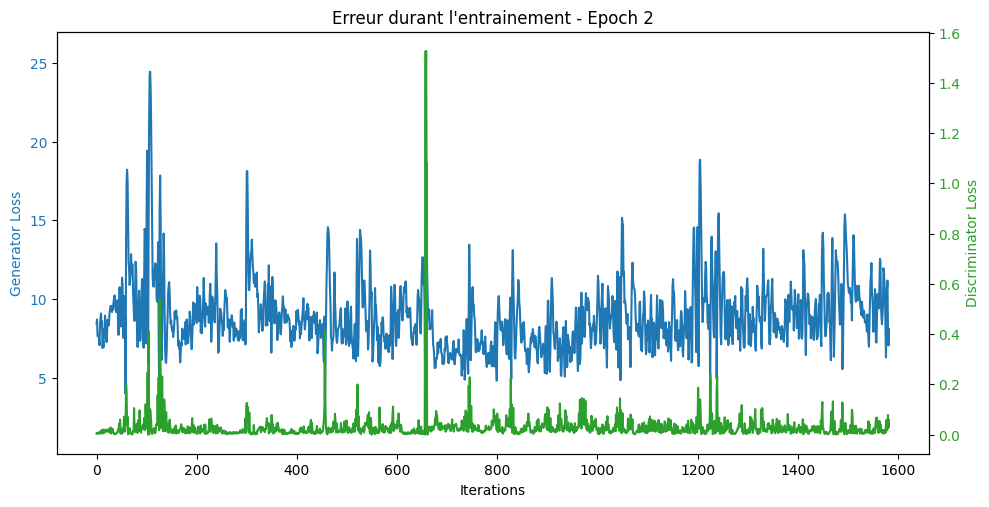

  0%|          | 0/1583 [00:00<?, ?it/s]

[3/10][0/1583] Loss_D: 0.0228 Loss_G: 9.5398 D(x): 0.9974 D(G(z)): 0.0367 / 0.0006
[3/10][158/1583] Loss_D: 0.0044 Loss_G: 9.4666 D(x): 0.9966 D(G(z)): 0.0051 / 0.0005
[3/10][316/1583] Loss_D: 0.0300 Loss_G: 7.8721 D(x): 0.9728 D(G(z)): 0.0112 / 0.0023
[3/10][474/1583] Loss_D: 0.0389 Loss_G: 6.5519 D(x): 0.9843 D(G(z)): 0.0451 / 0.0084
[3/10][632/1583] Loss_D: 0.0219 Loss_G: 8.4108 D(x): 0.9924 D(G(z)): 0.0199 / 0.0044
[3/10][790/1583] Loss_D: 0.0065 Loss_G: 10.1821 D(x): 0.9946 D(G(z)): 0.0040 / 0.0005
[3/10][948/1583] Loss_D: 0.0256 Loss_G: 8.7463 D(x): 0.9974 D(G(z)): 0.0361 / 0.0020
[3/10][1106/1583] Loss_D: 0.0259 Loss_G: 8.2873 D(x): 0.9830 D(G(z)): 0.0116 / 0.0020
[3/10][1264/1583] Loss_D: 0.0034 Loss_G: 11.3254 D(x): 0.9976 D(G(z)): 0.0035 / 0.0010
[3/10][1422/1583] Loss_D: 0.0416 Loss_G: 7.9032 D(x): 0.9605 D(G(z)): 0.0048 / 0.0022
[3/10][1580/1583] Loss_D: 0.0083 Loss_G: 10.7454 D(x): 0.9885 D(G(z)): 0.0003 / 0.0004


  0%|          | 0/1583 [00:00<?, ?it/s]

[4/10][0/1583] Loss_D: 0.0714 Loss_G: 7.5443 D(x): 0.9996 D(G(z)): 0.0899 / 0.0044
[4/10][158/1583] Loss_D: 0.0407 Loss_G: 6.9888 D(x): 0.9818 D(G(z)): 0.0362 / 0.0042
[4/10][316/1583] Loss_D: 0.0317 Loss_G: 10.9945 D(x): 0.9663 D(G(z)): 0.0021 / 0.0013
[4/10][474/1583] Loss_D: 0.0262 Loss_G: 5.8619 D(x): 0.9583 D(G(z)): 0.0051 / 0.0064
[4/10][632/1583] Loss_D: 0.0222 Loss_G: 7.1298 D(x): 0.9802 D(G(z)): 0.0178 / 0.0027
[4/10][790/1583] Loss_D: 0.0210 Loss_G: 8.0951 D(x): 0.9717 D(G(z)): 0.0044 / 0.0023
[4/10][948/1583] Loss_D: 0.0076 Loss_G: 10.6360 D(x): 0.9957 D(G(z)): 0.0090 / 0.0005
[4/10][1106/1583] Loss_D: 0.0341 Loss_G: 9.8960 D(x): 0.9634 D(G(z)): 0.0041 / 0.0012
[4/10][1264/1583] Loss_D: 0.0322 Loss_G: 7.0934 D(x): 0.9978 D(G(z)): 0.0484 / 0.0082
[4/10][1422/1583] Loss_D: 0.0065 Loss_G: 10.1938 D(x): 0.9923 D(G(z)): 0.0037 / 0.0047
[4/10][1580/1583] Loss_D: 0.0332 Loss_G: 7.9953 D(x): 0.9693 D(G(z)): 0.0193 / 0.0023


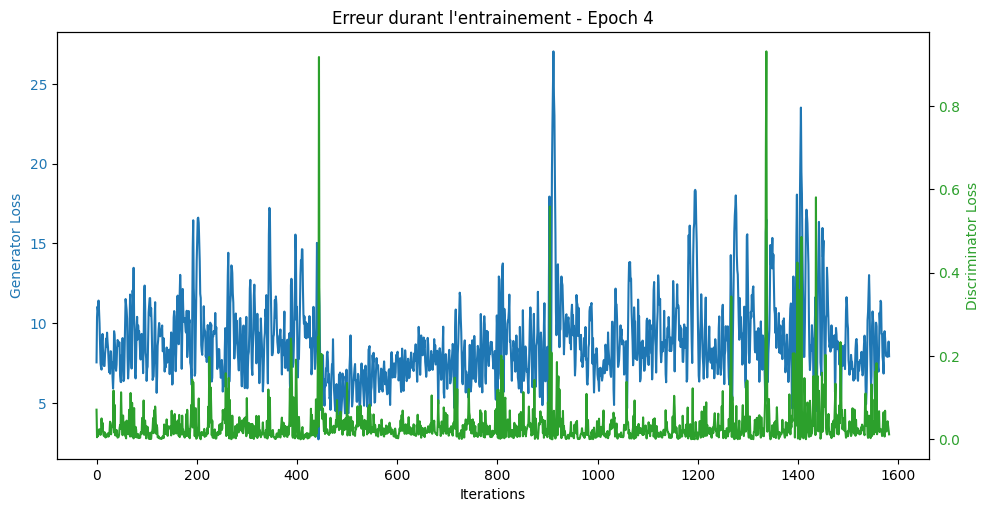

  0%|          | 0/1583 [00:00<?, ?it/s]

[5/10][0/1583] Loss_D: 0.0200 Loss_G: 7.8127 D(x): 0.9844 D(G(z)): 0.0158 / 0.0042
[5/10][158/1583] Loss_D: 0.0122 Loss_G: 7.8878 D(x): 0.9885 D(G(z)): 0.0099 / 0.0044
[5/10][316/1583] Loss_D: 0.0344 Loss_G: 14.1864 D(x): 0.9562 D(G(z)): 0.0011 / 0.0003
[5/10][474/1583] Loss_D: 0.0088 Loss_G: 8.5815 D(x): 0.9880 D(G(z)): 0.0029 / 0.0014
[5/10][632/1583] Loss_D: 0.0085 Loss_G: 8.1846 D(x): 0.9978 D(G(z)): 0.0142 / 0.0008
[5/10][790/1583] Loss_D: 0.0024 Loss_G: 6.8582 D(x): 0.9993 D(G(z)): 0.0040 / 0.0160
[5/10][948/1583] Loss_D: 0.0250 Loss_G: 8.6614 D(x): 0.9681 D(G(z)): 0.0039 / 0.0012
[5/10][1106/1583] Loss_D: 0.0033 Loss_G: 16.3968 D(x): 0.9939 D(G(z)): 0.0000 / 0.0000
[5/10][1264/1583] Loss_D: 0.0189 Loss_G: 10.4810 D(x): 0.9786 D(G(z)): 0.0023 / 0.0007
[5/10][1422/1583] Loss_D: 0.0277 Loss_G: 9.9202 D(x): 0.9712 D(G(z)): 0.0044 / 0.0008
[5/10][1580/1583] Loss_D: 0.0334 Loss_G: 7.8627 D(x): 0.9535 D(G(z)): 0.0075 / 0.0018


  0%|          | 0/1583 [00:00<?, ?it/s]

[6/10][0/1583] Loss_D: 0.4991 Loss_G: 5.8915 D(x): 0.9811 D(G(z)): 0.4787 / 0.0154
[6/10][158/1583] Loss_D: 0.0131 Loss_G: 9.8332 D(x): 0.9817 D(G(z)): 0.0001 / 0.0005
[6/10][316/1583] Loss_D: 0.0224 Loss_G: 6.7874 D(x): 0.9898 D(G(z)): 0.0191 / 0.0131
[6/10][474/1583] Loss_D: 0.0161 Loss_G: 9.1944 D(x): 0.9719 D(G(z)): 0.0009 / 0.0005
[6/10][632/1583] Loss_D: 0.0160 Loss_G: 10.3088 D(x): 0.9755 D(G(z)): 0.0035 / 0.0014
[6/10][790/1583] Loss_D: 0.0285 Loss_G: 6.8499 D(x): 0.9600 D(G(z)): 0.0047 / 0.0048
[6/10][948/1583] Loss_D: 0.0820 Loss_G: 6.9209 D(x): 0.9984 D(G(z)): 0.0896 / 0.0096
[6/10][1106/1583] Loss_D: 0.0138 Loss_G: 7.4566 D(x): 0.9883 D(G(z)): 0.0122 / 0.0036
[6/10][1264/1583] Loss_D: 0.0753 Loss_G: 9.7760 D(x): 0.9372 D(G(z)): 0.0007 / 0.0023
[6/10][1422/1583] Loss_D: 0.0431 Loss_G: 6.1625 D(x): 0.9550 D(G(z)): 0.0264 / 0.0259
[6/10][1580/1583] Loss_D: 0.0206 Loss_G: 10.1128 D(x): 0.9721 D(G(z)): 0.0019 / 0.0011


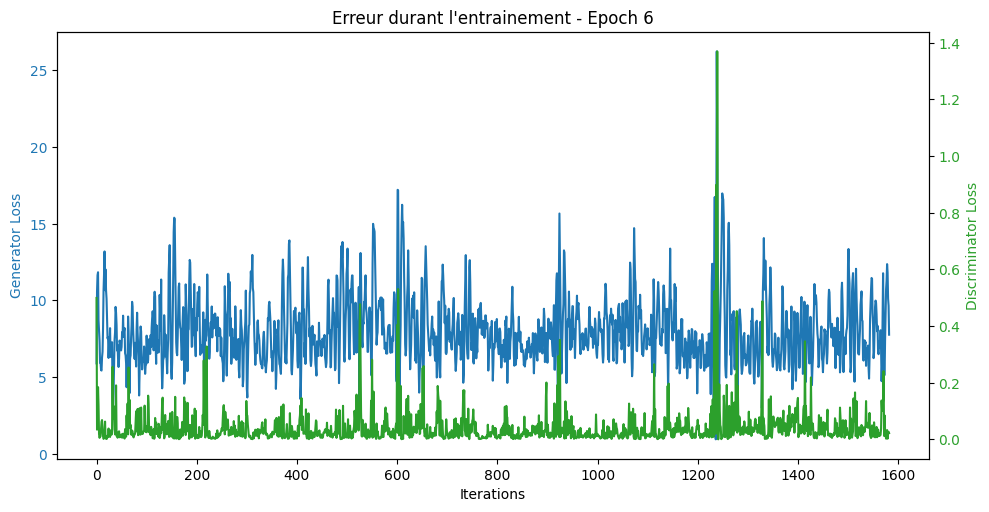

  0%|          | 0/1583 [00:00<?, ?it/s]

[7/10][0/1583] Loss_D: 0.0232 Loss_G: 6.5241 D(x): 0.9964 D(G(z)): 0.0273 / 0.0201
[7/10][158/1583] Loss_D: 0.0232 Loss_G: 5.3063 D(x): 0.9998 D(G(z)): 0.0356 / 0.0367
[7/10][316/1583] Loss_D: 0.0250 Loss_G: 6.9019 D(x): 0.9843 D(G(z)): 0.0254 / 0.0099
[7/10][474/1583] Loss_D: 0.0748 Loss_G: 6.0192 D(x): 0.9965 D(G(z)): 0.1037 / 0.0152
[7/10][632/1583] Loss_D: 0.0457 Loss_G: 6.4595 D(x): 0.9639 D(G(z)): 0.0186 / 0.0091
[7/10][790/1583] Loss_D: 0.0159 Loss_G: 8.7426 D(x): 0.9850 D(G(z)): 0.0121 / 0.0012
[7/10][948/1583] Loss_D: 0.0255 Loss_G: 6.1452 D(x): 0.9778 D(G(z)): 0.0122 / 0.0159
[7/10][1106/1583] Loss_D: 0.0136 Loss_G: 8.2652 D(x): 0.9994 D(G(z)): 0.0200 / 0.0033
[7/10][1264/1583] Loss_D: 0.0030 Loss_G: 7.3707 D(x): 0.9999 D(G(z)): 0.0057 / 0.0076
[7/10][1422/1583] Loss_D: 0.0132 Loss_G: 6.9403 D(x): 0.9884 D(G(z)): 0.0116 / 0.0093
[7/10][1580/1583] Loss_D: 0.0324 Loss_G: 9.8772 D(x): 0.9652 D(G(z)): 0.0031 / 0.0003


  0%|          | 0/1583 [00:00<?, ?it/s]

[8/10][0/1583] Loss_D: 0.0484 Loss_G: 5.4711 D(x): 0.9737 D(G(z)): 0.0427 / 0.0280
[8/10][158/1583] Loss_D: 0.0261 Loss_G: 7.9166 D(x): 0.9660 D(G(z)): 0.0020 / 0.0024
[8/10][316/1583] Loss_D: 0.0146 Loss_G: 8.1418 D(x): 0.9849 D(G(z)): 0.0118 / 0.0011
[8/10][474/1583] Loss_D: 0.0199 Loss_G: 6.4449 D(x): 0.9834 D(G(z)): 0.0191 / 0.0145
[8/10][632/1583] Loss_D: 0.0922 Loss_G: 6.9220 D(x): 1.0000 D(G(z)): 0.1168 / 0.0141
[8/10][790/1583] Loss_D: 0.0651 Loss_G: 8.2955 D(x): 0.9327 D(G(z)): 0.0050 / 0.0023
[8/10][948/1583] Loss_D: 0.0564 Loss_G: 8.8045 D(x): 0.9287 D(G(z)): 0.0059 / 0.0024
[8/10][1106/1583] Loss_D: 0.2575 Loss_G: 14.4648 D(x): 0.7951 D(G(z)): 0.0000 / 0.0000
[8/10][1264/1583] Loss_D: 0.0110 Loss_G: 5.4268 D(x): 0.9876 D(G(z)): 0.0086 / 0.0261
[8/10][1422/1583] Loss_D: 0.0341 Loss_G: 8.7294 D(x): 0.9758 D(G(z)): 0.0328 / 0.0014
[8/10][1580/1583] Loss_D: 0.0117 Loss_G: 7.7816 D(x): 0.9897 D(G(z)): 0.0114 / 0.0022


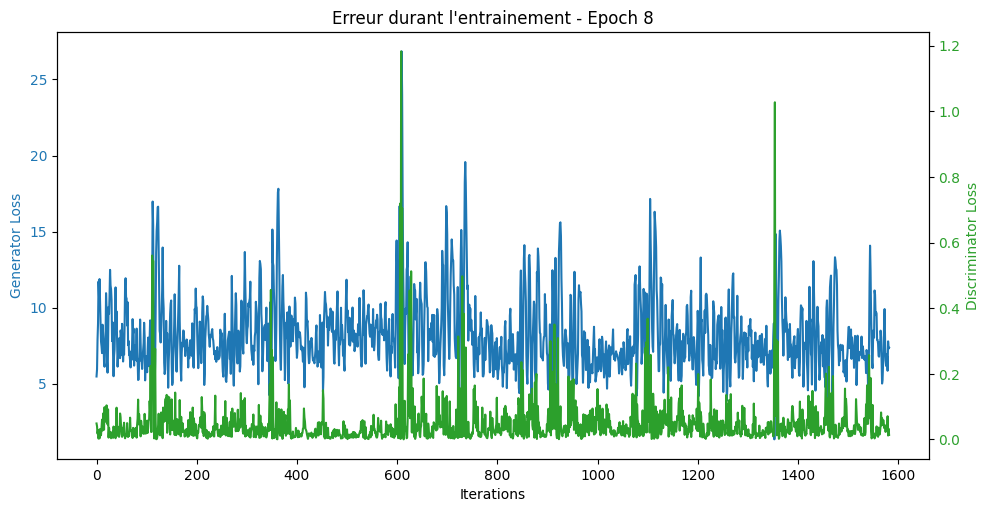

  0%|          | 0/1583 [00:00<?, ?it/s]

[9/10][0/1583] Loss_D: 0.0440 Loss_G: 6.5753 D(x): 0.9626 D(G(z)): 0.0277 / 0.0100
[9/10][158/1583] Loss_D: 0.0337 Loss_G: 4.3606 D(x): 0.9940 D(G(z)): 0.0446 / 0.0624
[9/10][316/1583] Loss_D: 0.0072 Loss_G: 7.3358 D(x): 0.9901 D(G(z)): 0.0034 / 0.0045
[9/10][474/1583] Loss_D: 0.0619 Loss_G: 6.7309 D(x): 0.9174 D(G(z)): 0.0100 / 0.0081
[9/10][632/1583] Loss_D: 0.0473 Loss_G: 12.7499 D(x): 0.9309 D(G(z)): 0.0001 / 0.0001
[9/10][790/1583] Loss_D: 0.0230 Loss_G: 6.8752 D(x): 0.9960 D(G(z)): 0.0385 / 0.0047
[9/10][948/1583] Loss_D: 0.0270 Loss_G: 5.5307 D(x): 0.9948 D(G(z)): 0.0434 / 0.0131
[9/10][1106/1583] Loss_D: 0.0049 Loss_G: 11.7672 D(x): 0.9916 D(G(z)): 0.0004 / 0.0000
[9/10][1264/1583] Loss_D: 0.0027 Loss_G: 9.3421 D(x): 0.9996 D(G(z)): 0.0047 / 0.0006
[9/10][1422/1583] Loss_D: 0.0153 Loss_G: 7.3027 D(x): 0.9890 D(G(z)): 0.0165 / 0.0056
[9/10][1580/1583] Loss_D: 0.0112 Loss_G: 13.9432 D(x): 0.9824 D(G(z)): 0.0001 / 0.0000


  0%|          | 0/1583 [00:00<?, ?it/s]

[10/10][0/1583] Loss_D: 0.0037 Loss_G: 7.6733 D(x): 0.9993 D(G(z)): 0.0064 / 0.0100
[10/10][158/1583] Loss_D: 0.0335 Loss_G: 6.2517 D(x): 0.9851 D(G(z)): 0.0421 / 0.0134
[10/10][316/1583] Loss_D: 0.0240 Loss_G: 6.9380 D(x): 0.9985 D(G(z)): 0.0388 / 0.0076
[10/10][474/1583] Loss_D: 0.0278 Loss_G: 8.1294 D(x): 0.9698 D(G(z)): 0.0040 / 0.0039
[10/10][632/1583] Loss_D: 0.0075 Loss_G: 9.9374 D(x): 0.9959 D(G(z)): 0.0091 / 0.0019
[10/10][790/1583] Loss_D: 0.0349 Loss_G: 8.8598 D(x): 0.9643 D(G(z)): 0.0208 / 0.0018
[10/10][948/1583] Loss_D: 0.3390 Loss_G: 10.7189 D(x): 0.9999 D(G(z)): 0.3728 / 0.0002
[10/10][1106/1583] Loss_D: 0.0171 Loss_G: 8.2359 D(x): 0.9850 D(G(z)): 0.0155 / 0.0031
[10/10][1264/1583] Loss_D: 0.0199 Loss_G: 8.1314 D(x): 0.9715 D(G(z)): 0.0053 / 0.0020
[10/10][1422/1583] Loss_D: 0.0388 Loss_G: 5.3097 D(x): 0.9985 D(G(z)): 0.0541 / 0.0479
[10/10][1580/1583] Loss_D: 0.0911 Loss_G: 6.6930 D(x): 0.9956 D(G(z)): 0.1122 / 0.0105


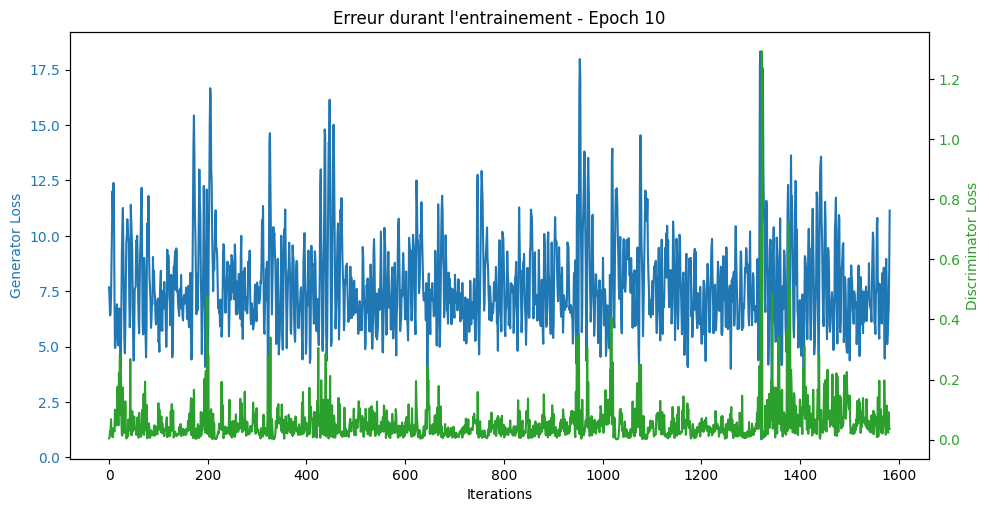

In [ ]:
import torch.optim as optim # pour les optimiseurs
from tqdm.notebook import tqdm # pour suivre la progression du training

optimizerD = optim.Adam(netD.parameters(), lr=0.0002)
optimizerG = optim.Adam(netG.parameters(), lr=0.0002)
func_perte = nn.BCELoss() # fonction de loss, ici l'entropie croisée binaire
nb_epochs = 10

for epoch in range(1, nb_epochs+1):
    G_losses = []
    D_losses = []
    for i, data in enumerate(tqdm(dataloader)):

        # 1. grad sur D: maximization de log(D(x)) + log(1 - D(G(z)))

        # training avec real images
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), 1, dtype=torch.float, device=device)

        # real image
        output = netD(real_cpu).view(-1)
        D_x = output.mean().item() # moyenne de sortie sur img_real
        lossD_real = func_perte(output, label)
        lossD_real.backward()

        # training avec fake images
        noises = torch.randn(b_size, nz, 1, 1, device=device) # bruit pour generer des fakes
        fake = netG(noises)
        label.fill_(0)

        output = netD(fake.detach()).view(-1) # pas de rétropropagation sur D
        D_G_z1 = output.mean().item() # moyenne de sortie sur les fake apres passage dans D
        lossD_fake = func_perte(output, label)
        lossD_fake.backward()

        lossD = (lossD_real + lossD_fake)/2
        optimizerD.step()


        # 2. grad sur  G: maximization de log(D(G(z)))
        netG.zero_grad()
        label.fill_(1)  # fake_labels sont les vraies pour le cout du generator
        output = netD(fake).view(-1)
        D_G_z2 = output.mean().item() # moyenne de sortie sur les fake apres passage dans G

        lossG = func_perte(output, label)
        lossG.backward()
        optimizerG.step()


        # log des pertes et moyennes de sorties
        if i % (len(dataloader) // 10) == 0: # tous les 10% du dataloader

            print(f"[{epoch}/{nb_epochs}][{i}/{len(dataloader)}] "
              f"Loss_D: {lossD.item():.4f} Loss_G: {lossG.item():.4f} "
              f"D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}")

        G_losses.append(lossG.item())
        D_losses.append(lossD.item())
        #c += 1

    with torch.no_grad():
        noise = torch.randn(64, nz, 1, 1, device=device)
        fake = netG(noise).cpu()

    save_dir = "drive/My Drive/Colab Notebooks/tp_gan/test"
    os.makedirs(save_dir, exist_ok=True)

    save_path = os.path.join(save_dir, f"fake_images_epoch_{epoch}.png")
    vutils.save_image(fake, save_path, normalize=True) # save image

    # courbe des pertes
    if epoch % 2 == 0:
        """
        plt.figure(figsize=(10,5))
        plt.title(f"Erreur normalisée durant l'entrainement - Epoch {epoch}")

        #G_losses_norma = (G_losses - np.min(G_losses)) / (np.max(G_losses) - np.min(G_losses))
        #D_losses_norma = (D_losses - np.min(D_losses)) / (np.max(D_losses) - np.min(D_losses))

        #plt.plot(G_losses,label="Generator")
        #plt.plot(D_losses,label="Discriminator")
        plt.plot(G_losses_norma,label="Generator")
        plt.plot(D_losses_norma,label="Discriminator")

        plt.xlabel("iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(os.path.join(save_dir, f"loss_curve_epoch_{epoch}.png")) # save the curve
        plt.show()
        plt.close()

        """
        fig, ax1 = plt.subplots(figsize=(10,5))
        # 2 courbes sur le même échelle avec 2 axes y
        ax1.set_xlabel("Iterations")

        ax1.set_ylabel("Generator Loss", color='tab:blue')
        ax1.plot(G_losses, label="Generator", color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        ax2 = ax1.twinx()

        ax2.set_ylabel("Discriminator Loss", color='tab:green')
        ax2.plot(D_losses, label="Discriminator", color='tab:green')
        ax2.tick_params(axis='y', labelcolor='tab:green')

        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.title(f"Erreur durant l'entrainement - Epoch {epoch}")
        plt.savefig(os.path.join(save_dir, f"loss_curve_epoch_{epoch}.png"))
        plt.show()
        plt.close()

# inspiration en partie de :
# https://github.com/PhilipVinc/VariationalNoiseLearning/blob/main/testGAN.py
# https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/gan/gan.py#L121

Le code ci-dessous applique votre réseau à un batch de $z$ aléatoires et affiche les images générées (et enregistre dans fake.png).

In [ ]:
noise = torch.randn(64, nz, 1, 1, device=device)
with torch.no_grad():
  netG.eval()
  fake = netG(noise).detach().cpu()
img=vutils.make_grid(fake, padding=2, normalize=True)
#img_list.append(img)
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img.cpu(),(1,2,0)))
plt.savefig( "fake.png" )

Output hidden; open in https://colab.research.google.com to view.

Le générateur du papier original DCGAN possède en fait l'architecture suivante:

![Generator](https://pytorch.org/tutorials/_images/dcgan_generator.png)

Comme le réseau $G$ définit plus haut, il correspond à un empilement de couches de convolutions transposées (appelée dans certains papiers couches de déconvolution). Contrairement aux convolutions classiques qui mènent à une réduction de la taille des sorties, les convolutions transposées agrandissent les cartes de caractéristiques considérées (feature maps). C'est particulièrement adapté pour de la génération d'images à partir d'un code de petite taille (ici $z$).

 Pour comprendre comment fonctionne la convolution transposée, voici un exemple simple avec une entrée 2 x 2 et un noyau 2 x 2. Chaque élément de l'entrée (4 éléments) est multiplié par le noyau et le résultat est ajouté à la sorte de taille 3 x 3:

![BasicTransposeConv2D](http://d2l.ai/_images/trans-conv.svg)

Et voici deux animations pour se représenter l'opération d'une manière plus générale. A gauche on utilise un stride de 1, à droite un stride de 2:

<p align="center">
<img src="https://i.stack.imgur.com/YyCu2.gif">
<img src="https://i.stack.imgur.com/f2RiP.gif">
</p>


Suivant la doc Pytorch de torch.nn.ConvTranspose2d, la hauteur $H_{out}$ et la largeur $W_{out}$ des cartes de sortie du ConvTranspose2d peuvent se calculer de la manière suivante:

$H_{out}$=($H_{in}$−1)×stride−2×padding+dilation×(kernel_size−1)+output_padding+1

$W_{out}$=($W_{in}$−1)×stride−2×padding+dilation×(kernel_size−1)+output_padding+1


Proposer un nouveau réseau $G$ qui respecte l'architecture du schéma du papier DCGAN et comparer les résultats. On gardera le paramètre de dilation à sa valeur de 1 par défaut mais il est possible de moduler les valeurs de padding et output_padding pour obtenir des sorties de la taille désirée.


In [12]:
nz=100  #Taille du vecteur z donné en entrée du générateur
ngf = 64 # Facteur du nombre de canaux de sortie des différentes couches de deconvolution

class GeneratorDCGAN(nn.Module):
    def __init__(self):
        super(GeneratorDCGAN, self).__init__()
        # (Etape Project): Couche pour passer de z à la taille de la 1er couche de deconvolution
        self.fc = nn.Linear( nz, ngf * 16 * 4 * 4)
        self.main = nn.Sequential(

            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d( ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        x = input.view(input.size(0), -1) # "aplatissage" de l'input
        x = self.fc(x) # projection
        x = x.view(-1, ngf * 16, 4, 4) # reshape
        return self.main(x)


netD = Discriminator().to(device)
netD.apply(weights_init)

netG_dcgan = GeneratorDCGAN().to(device)
netG_dcgan.apply(weights_init)
netG_dcgan

GeneratorDCGAN(
  (fc): Linear(in_features=100, out_features=16384, bias=True)
  (main): Sequential(
    (0): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(64, eps=1e

Entraînement+génération

In [13]:
import torch.optim as optim # pour les optimiseurs
from tqdm.notebook import tqdm # pour suivre la progression du training


optimizerD = optim.Adam(netD.parameters(), lr=0.0002)
optimizerG = optim.Adam(netG_dcgan.parameters(), lr=0.0002)
func_perte = nn.BCELoss() # fonction de loss, ici l'entropie croisée binaire
nb_epochs = 4

for epoch in range(1, nb_epochs+1):
    G_losses = []
    D_losses = []
    for i, data in enumerate(tqdm(dataloader)):

        # 1. grad sur D: maximization de log(D(x)) + log(1 - D(G(z)))

        # training avec real images
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), 1, dtype=torch.float, device=device)

        # real image
        output = netD(real_cpu).view(-1)
        D_x = output.mean().item() # moyenne de sortie sur img_real
        lossD_real = func_perte(output, label)
        lossD_real.backward()

        # training avec fake images
        noises = torch.randn(b_size, nz, 1, 1, device=device) # bruit pour generer des fakes
        fake = netG_dcgan(noises)
        label.fill_(0)

        output = netD(fake.detach()).view(-1) # pas de rétropropagation sur D
        D_G_z1 = output.mean().item() # moyenne de sortie sur les fake apres passage dans D
        lossD_fake = func_perte(output, label)
        lossD_fake.backward()

        lossD = (lossD_real + lossD_fake)/2
        optimizerD.step()


        # 2. grad sur  G: maximization de log(D(G(z)))
        netG_dcgan.zero_grad()
        label.fill_(1)  # fake_labels sont les vraies pour le cout du generator
        output = netD(fake).view(-1)
        D_G_z2 = output.mean().item() # moyenne de sortie sur les fake apres passage dans G

        lossG = func_perte(output, label)
        lossG.backward()
        optimizerG.step()


        # log des pertes et moyennes de sorties
        if i % (len(dataloader) // 10) == 0: # tous les 10% du dataloader

            print(f"[{epoch}/{nb_epochs}][{i}/{len(dataloader)}] "
              f"Loss_D: {lossD.item():.4f} Loss_G: {lossG.item():.4f} "
              f"D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}")

        G_losses.append(lossG.item())
        D_losses.append(lossD.item())
        #c += 1

    with torch.no_grad():
        noise = torch.randn(64, nz, 1, 1, device=device)
        fake = netG_dcgan(noise).cpu()

    save_dir = "drive/My Drive/Colab Notebooks/tp_gan/dcgan"
    os.makedirs(save_dir, exist_ok=True)

    save_path = os.path.join(save_dir, f"fake_images_epoch_{epoch}.png")
    vutils.save_image(fake, save_path, normalize=True) # save image

    # courbe des pertes
    if epoch % 2 == 0:

        fig, ax1 = plt.subplots(figsize=(10,5))
        # 2 courbes sur le même échelle avec 2 axes y
        ax1.set_xlabel("Iterations")

        ax1.set_ylabel("Generator Loss", color='tab:blue')
        ax1.plot(G_losses, label="Generator", color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        ax2 = ax1.twinx()

        ax2.set_ylabel("Discriminator Loss", color='tab:green')
        ax2.plot(D_losses, label="Discriminator", color='tab:green')
        ax2.tick_params(axis='y', labelcolor='tab:green')

        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.title(f"Erreur durant l'entrainement - Epoch {epoch}")
        plt.savefig(os.path.join(save_dir, f"loss_curve_epoch_{epoch}.png"))
        plt.show()
        plt.close()

# inspiration en partie de :
# https://github.com/PhilipVinc/VariationalNoiseLearning/blob/main/testGAN.py
# https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/gan/gan.py#L121

  0%|          | 0/1583 [00:00<?, ?it/s]

ValueError: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([3200])) is deprecated. Please ensure they have the same size.

Bonus: Réaliser le même genre d'apprentissage sur le corpus Mnist (Dataloader existant dans torch pour télécharger et charger le corpus)

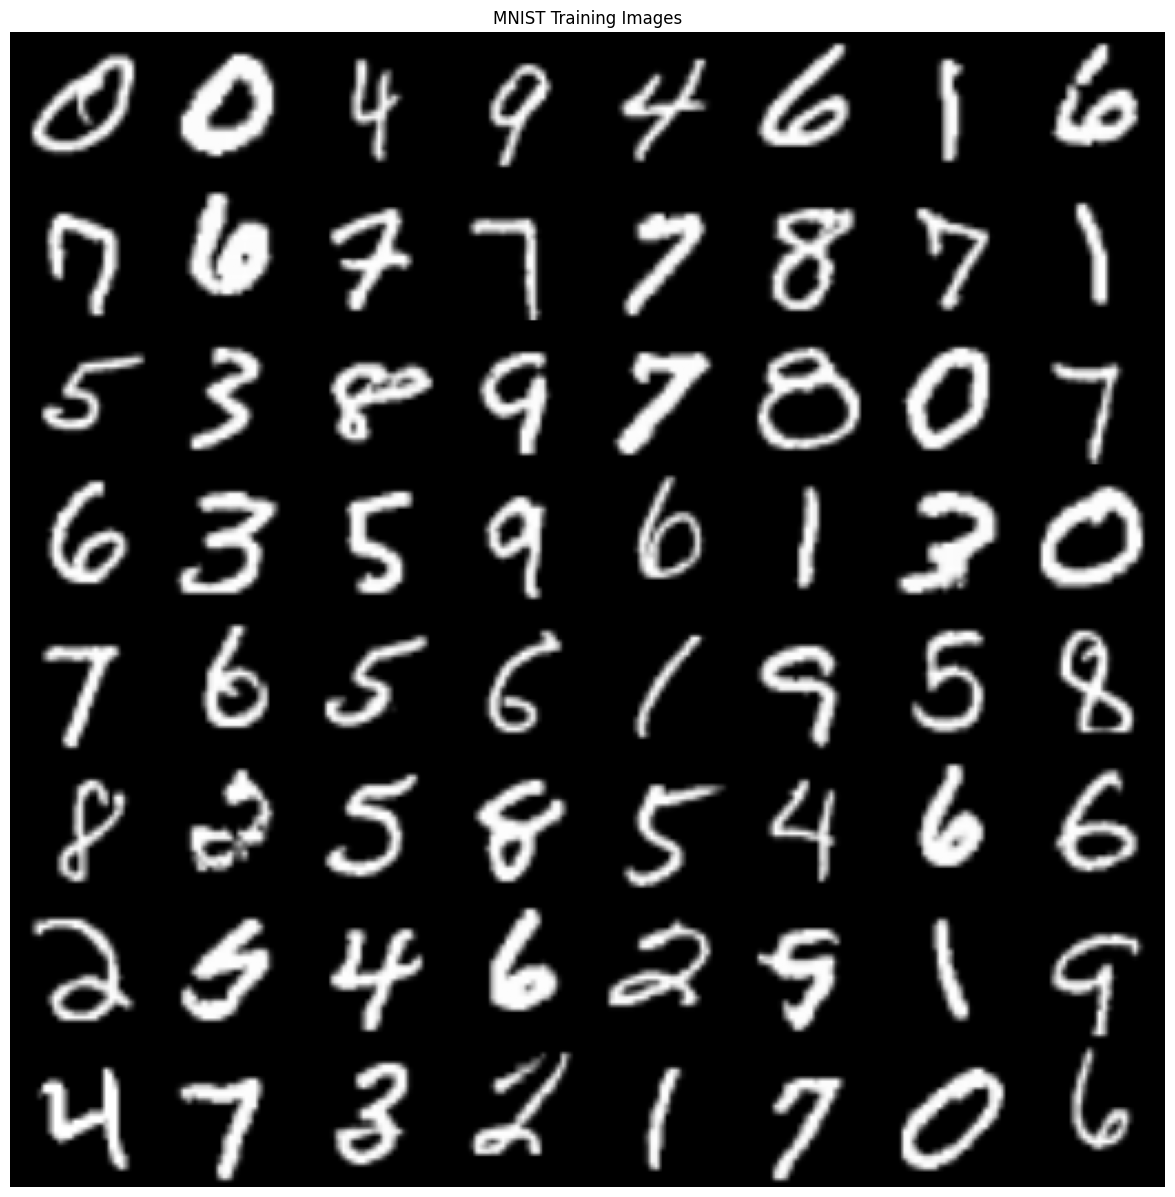

In [ ]:
mnist_dataset = dset.MNIST(root='./data', train=True, download=True,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                           ]))

mnist_dataloader = torch.utils.data.DataLoader(mnist_dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=workers)

real_batch = next(iter(mnist_dataloader))
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("MNIST Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=1, normalize=True).cpu(),(1,2,0)))
plt.show()